In [1]:
import datetime
import os
import sys
import argparse
import glob
import pprint
import traceback
import numpy as np

import pandas as pd

from osgeo import gdal

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [2]:
t1 = datetime.datetime.now()
print(t1.strftime("%Y-%m-%d %H:%M:%S\n"))

2017-11-16 13:59:03



In [3]:
def get_files(path, year=None, lookfor="CoverFromTo"):
    """

    :param path:
    :param year:
    :param lookfor:
    :return:
    """
    # All files in path ending in .tif
    filelist = glob.glob(f"{path}{os.sep}{lookfor}*.tif")

    filelist.sort()

    if len(filelist) == 0:
        print("\nCould not locate a files {}\n".format(path))

        sys.exit(1)

    if year is None:
        return filelist

    else:
        return [f for f in filelist if year in f]

In [4]:
def read_data(infile):
    """

    :param infile:
    :return:
    """
    # Load raster data into an array
    data = gdal.Open(infile, gdal.GA_ReadOnly).ReadAsArray()

    # Obtain unique class values from the array
    vals = np.unique(data)

    return data

In [5]:
def get_fname(f):
    
    basename = os.path.splitext(os.path.basename(f))[0]

    return f"{basename}_cnf"

In [6]:
def write_to_csv(matrix, outdir, name, lookfor="99999999"):

    if os.path.exists('%s/%s.csv' % (outdir, lookfor)):
        os.remove('%s/%s.csv' % (outdir, lookfor))

    if os.path.exists('%s/%s.csv' % (outdir, name)):
        os.remove('%s/%s.csv' % (outdir, name))

    # save the confusion matrix to a temporary .csv file named 999999.csv
    np.savetxt('%s/%s.csv' % (outdir, lookfor), matrix, fmt='%d')

    # open the temp .csv file and a new final output csv file named with the fname variable
    with open('%s/%s.csv' % (outdir, lookfor), 'r') as f:

        text = f.read()

        text = text.replace(lookfor, 'Total')

    with open('%s/%s.csv' % (outdir, name), 'w') as out:

        out.write(text)

    for dirpath, folders, files in os.walk(outdir):

        for x in files:

            if x == '99999999.csv':
                os.remove(os.path.join(dirpath, x))

    return None

In [7]:
def array_to_dataframe(matrix):
    
    df = pd.DataFrame(matrix[1:, 1:], index=matrix[1:, 0], columns=matrix[0, 1:])

    # Find and replace 99999999 with "Total"
    try:

        # Find in dataframe index
        ind_list = df.index.tolist()

        idx = ind_list.index(99999999)

        ind_list[idx] = "Total"

        df.index = ind_list

        # Find in dataframe columns
        col_list = df.columns.tolist()

        idx = col_list.index(99999999)

        col_list[idx] = "Total"

        df.columns = col_list

    except ValueError:
        pass

    return df

In [8]:
def write_to_excel(loc, df, basename):
    # Create a Pandas Excel writer using XlsxWriter as the engine
    writer = pd.ExcelWriter(loc + os.sep + "{name}.xlsx".format(name=basename),
                            engine="xlsxwriter")

    # Convert the dataframe to an XLsxWriter Excel object
    df.to_excel(writer, sheet_name=f"{basename}")

    # Close the Pandas Excel writer and output the Excel file
    writer.save()

    return None

### Set up input parameters

In [9]:
input_dir = r"D:\LCMAP\ARD_h21v08\maps"
output_dir = r"D:\LCMAP\ARD_h21v08\cnf"
year = "1990"
tile = "H21V08"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

in_files = get_files(path=input_dir, year=year)

pprint.pprint(in_files)

in_data = read_data(in_files[0])

['D:\\LCMAP\\ARD_h21v08\\maps\\CoverFromTo_1990.tif']


### Generate confusion matrix

In [10]:
from_vals, to_vals = [1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]

fromto = np.copy(in_data)

total = float(len(from_vals) * len(to_vals))

check_vals = np.unique(fromto)

# create the confusion matrix, for now containing all zeros
confusion_matrix = np.zeros((len(from_vals), len(to_vals)), np.int32)

print("generating %s by %s confusion matrix" % (len(to_vals), len(from_vals)))

counter = 1.0

# loop through columns
for c in to_vals:

    # loop through rows
    for r in from_vals:
        val = int(str(c) + str(r))

        current = counter / total * 100.0  # as percent

        if val in check_vals:

            # (c, r) means 'from' is vertical axis and 'to' is the horizontal axis
            confusion_matrix[to_vals.index(c), from_vals.index(r)] = np.bincount(fromto.flatten())[val]

        else:

            confusion_matrix[to_vals.index(c), from_vals.index(r)] = 0
    
confusion_matrix

generating 8 by 8 confusion matrix


array([[42759, 13269,   154,  1401,  1680,   126,     0,    89],
       [13246, 19649,    31,   680,   565,   145,     0,   114],
       [  173,    81,     9,    17,     6,    11,     0,     1],
       [ 3003,   468,    20,   478,   230,    93,     0,     8],
       [  933,   150,     4,    98,  3093,   197,     0,     5],
       [   94,    84,     7,    37,   170,   333,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0],
       [  275,   173,     0,     6,    14,     4,     0,     0]])

In [11]:
# add row totals in a new column at the end
x_sum = confusion_matrix.sum(axis=1)

x_sum = np.reshape(x_sum, (len(from_vals), 1))

confusion_matrix = np.append(arr=confusion_matrix, values=x_sum, axis=1)

# add column totals in a new row at the end
y_sum = confusion_matrix.sum(axis=0)

y_sum = np.reshape(y_sum, (1, len(to_vals) + 1))

confusion_matrix = np.append(arr=confusion_matrix, values=y_sum, axis=0)

confusion_matrix



array([[ 42759,  13269,    154,   1401,   1680,    126,      0,     89,
         59478],
       [ 13246,  19649,     31,    680,    565,    145,      0,    114,
         34430],
       [   173,     81,      9,     17,      6,     11,      0,      1,
           298],
       [  3003,    468,     20,    478,    230,     93,      0,      8,
          4300],
       [   933,    150,      4,     98,   3093,    197,      0,      5,
          4480],
       [    94,     84,      7,     37,    170,    333,      0,      0,
           725],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0],
       [   275,    173,      0,      6,     14,      4,      0,      0,
           472],
       [ 60483,  33874,    225,   2717,   5758,    909,      0,    217,
        104183]])

In [12]:
# insert a blank row and column at the top/left to contain class values
confusion_matrix = np.insert(arr=confusion_matrix, obj=0, axis=0, values=0)

confusion_matrix = np.insert(arr=confusion_matrix, obj=0, axis=1, values=0)

confusion_matrix

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0,  42759,  13269,    154,   1401,   1680,    126,      0,
            89,  59478],
       [     0,  13246,  19649,     31,    680,    565,    145,      0,
           114,  34430],
       [     0,    173,     81,      9,     17,      6,     11,      0,
             1,    298],
       [     0,   3003,    468,     20,    478,    230,     93,      0,
             8,   4300],
       [     0,    933,    150,      4,     98,   3093,    197,      0,
             5,   4480],
       [     0,     94,     84,      7,     37,    170,    333,      0,
             0,    725],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0,    275,    173,      0,      6,     14,      4,      0,
             0,    472],
       [     0,  60483,  33874,    225,   2717,   5758,    909,      0,
           217, 104183]])

In [13]:
from_vals.insert(0, 0)
to_vals.insert(0, 0)

# 99999999 instead of 'total' because can't have strings in array of numbers
from_vals.append(99999999)
to_vals.append(99999999)

# insert the class names into the blank columns/rows of the matrix
for c in range(len(from_vals)):

    confusion_matrix[c, 0] = from_vals[c]
    confusion_matrix[0, c] = to_vals[c]

confusion_matrix

array([[       0,        1,        2,        3,        4,        5,
               6,        7,        8, 99999999],
       [       1,    42759,    13269,      154,     1401,     1680,
             126,        0,       89,    59478],
       [       2,    13246,    19649,       31,      680,      565,
             145,        0,      114,    34430],
       [       3,      173,       81,        9,       17,        6,
              11,        0,        1,      298],
       [       4,     3003,      468,       20,      478,      230,
              93,        0,        8,     4300],
       [       5,      933,      150,        4,       98,     3093,
             197,        0,        5,     4480],
       [       6,       94,       84,        7,       37,      170,
             333,        0,        0,      725],
       [       7,        0,        0,        0,        0,        0,
               0,        0,        0,        0],
       [       8,      275,      173,        0,        6,       

### Get Pandas Dataframe

In [14]:
df = array_to_dataframe(confusion_matrix)
df

,1,2,3,4,5,6,7,8,Total
1,42759,13269,154,1401,1680,126,0,89,59478
2,13246,19649,31,680,565,145,0,114,34430
3,173,81,9,17,6,11,0,1,298
4,3003,468,20,478,230,93,0,8,4300
5,933,150,4,98,3093,197,0,5,4480
6,94,84,7,37,170,333,0,0,725
7,0,0,0,0,0,0,0,0,0
8,275,173,0,6,14,4,0,0,472
Total,60483,33874,225,2717,5758,909,0,217,104183


In [15]:
df_percents = df.iloc[df.index != "Total"]
df_percents = df[[1, 2, 3, 4, 5, 6, 7, 8]].copy()
df_percents = df_percents.div(df_percents.sum(1)/100, 0)


In [16]:
counts = confusion_matrix[1:9, 1:9]
percents = np.zeros_like(counts, dtype=np.float)
print(counts)
nrows = np.shape(percents)[0]

for n in range(nrows):
    for ind, i in enumerate(counts[n]):
        # print(n, ind)
        if i:
            temp = float(i) / np.sum(counts[n]) * 100.0
            percents[n, ind] = temp

print(percents)

[[42759 13269   154  1401  1680   126     0    89]
 [13246 19649    31   680   565   145     0   114]
 [  173    81     9    17     6    11     0     1]
 [ 3003   468    20   478   230    93     0     8]
 [  933   150     4    98  3093   197     0     5]
 [   94    84     7    37   170   333     0     0]
 [    0     0     0     0     0     0     0     0]
 [  275   173     0     6    14     4     0     0]]
[[ 71.89044689  22.30908907   0.25891926   2.35549279   2.82457379
    0.21184303   0.           0.14963516]
 [ 38.47226256  57.06941621   0.09003776   1.97502178   1.64101075
    0.42114435   0.           0.33110659]
 [ 58.05369128  27.18120805   3.02013423   5.70469799   2.01342282
    3.69127517   0.           0.33557047]
 [ 69.8372093   10.88372093   0.46511628  11.11627907   5.34883721
    2.1627907    0.           0.18604651]
 [ 20.82589286   3.34821429   0.08928571   2.1875      69.04017857
    4.39732143   0.           0.11160714]
 [ 12.96551724  11.5862069    0.96551724   5.1

In [17]:
# Grab the total of all segment change

segment_total = confusion_matrix[1:9, -1]
segment_total = np.sum(segment_total)

segment_percent = segment_total / 25000000.0 * 100.0

print(segment_total, segment_percent)

104183 0.416732


In [18]:
# Grab the Percent of the tile that had thematic change
marker = [0,1,2,3,4,5,6,7]

tile_counts = []

for ind, i in enumerate(counts):
    temp=list(i)

    del(temp[marker[ind]])

    x = 0
    
    for i_x in temp:
        x = x + i_x
    
    tile_counts.append(x)

final_count = 0
for x in tile_counts:
    final_count = final_count + x
    
final_percent = final_count / 25000000.0 * 100.0
print(final_count, final_percent)

37862 0.151448


In [19]:
class_totals = confusion_matrix[:,-1][1:-1]
class_segment_proportions = [class_total / segment_total * 100 for class_total in class_totals]
class_areas = [class_total * 900 * .0009 for class_total in class_totals]

# Plotting
#### Plot colors and class names

In [20]:
colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 140, 0), (0, 0, 255), (0, 255, 255), 
          (245, 245, 245), (100, 100, 100)]

# Convert RGB 0-255 to RGB 0-1
colors_ = []
for c in colors:
    new_c = tuple([C / 255.0 for C in c])
    colors_.append(new_c)
pprint.pprint(colors_)

class_names = ["Developed", "Agriculture", "Grassland/Shrubland", "Tree Cover", "Water", "Wetland", "Ice/Snow", "Barren"]

[(1.0, 0.0, 0.0),
 (1.0, 0.6470588235294118, 0.0),
 (1.0, 1.0, 0.0),
 (0.0, 0.5490196078431373, 0.0),
 (0.0, 0.0, 1.0),
 (0.0, 1.0, 1.0),
 (0.9607843137254902, 0.9607843137254902, 0.9607843137254902),
 (0.39215686274509803, 0.39215686274509803, 0.39215686274509803)]


### Try Plotting

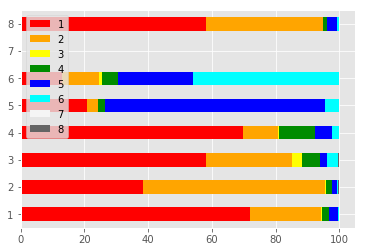

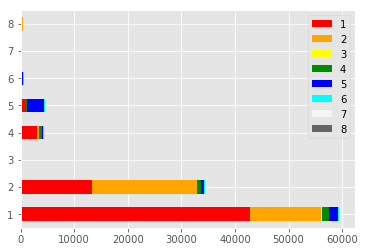

In [21]:
matplotlib.style.use("ggplot")

# Plot the percents
df_percents[:-1].plot.barh(stacked=True, color=colors_)
plt.show()

# Plot the counts
df.iloc[df.index != "Total"][[1,2,3,4,5,6,7,8]].plot.barh(stacked=True, color=colors_)
plt.show()

### Plot on shared Y-Axis using subplots

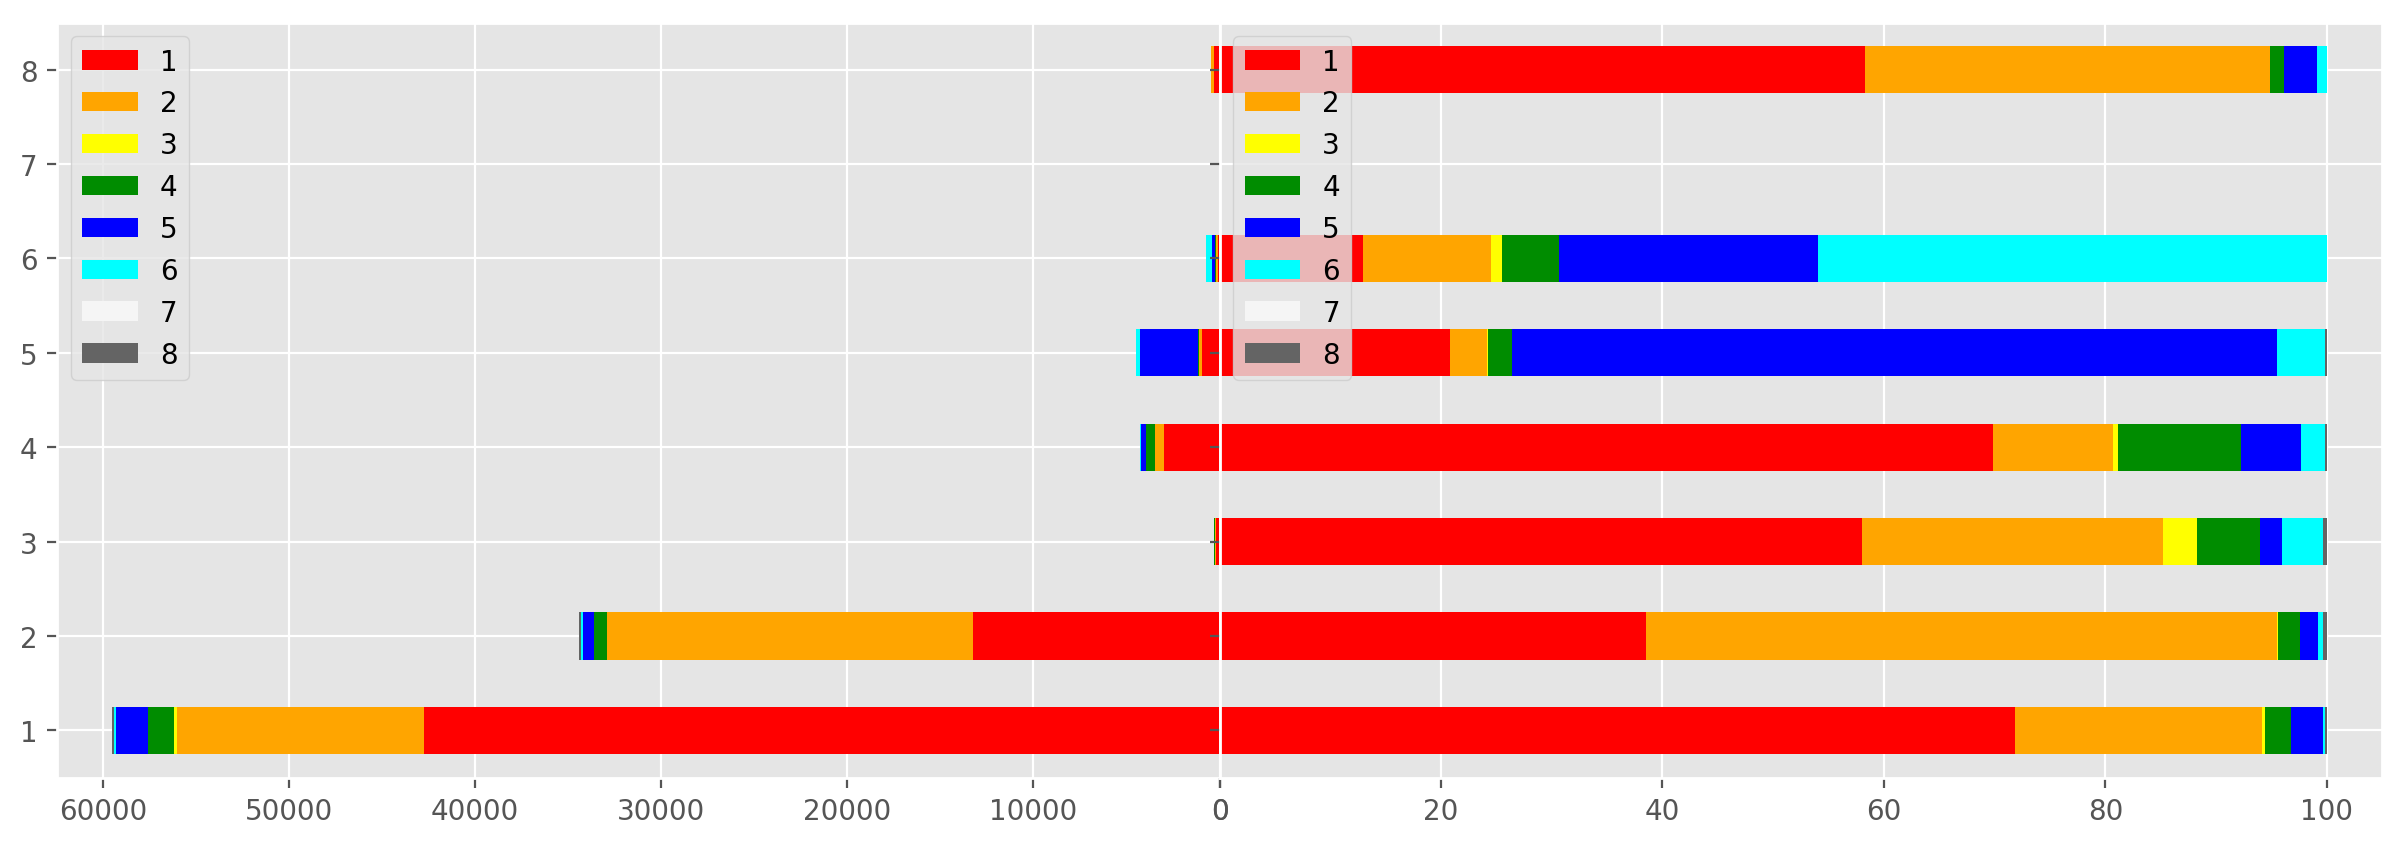

In [22]:
plt.close()

fig, (ax1, ax2) = plt.subplots(figsize=(15,5), dpi=200, nrows=1, ncols=2, sharex=False, sharey=True)

fig.subplots_adjust(wspace=0)

df_percents[:-1].plot.barh(stacked=True, color=colors_, ax=ax2)

df.iloc[df.index != "Total"][[1,2,3,4,5,6,7,8]].plot.barh(stacked=True, color=colors_, ax=ax1)

ax1.invert_xaxis()

plt.show()

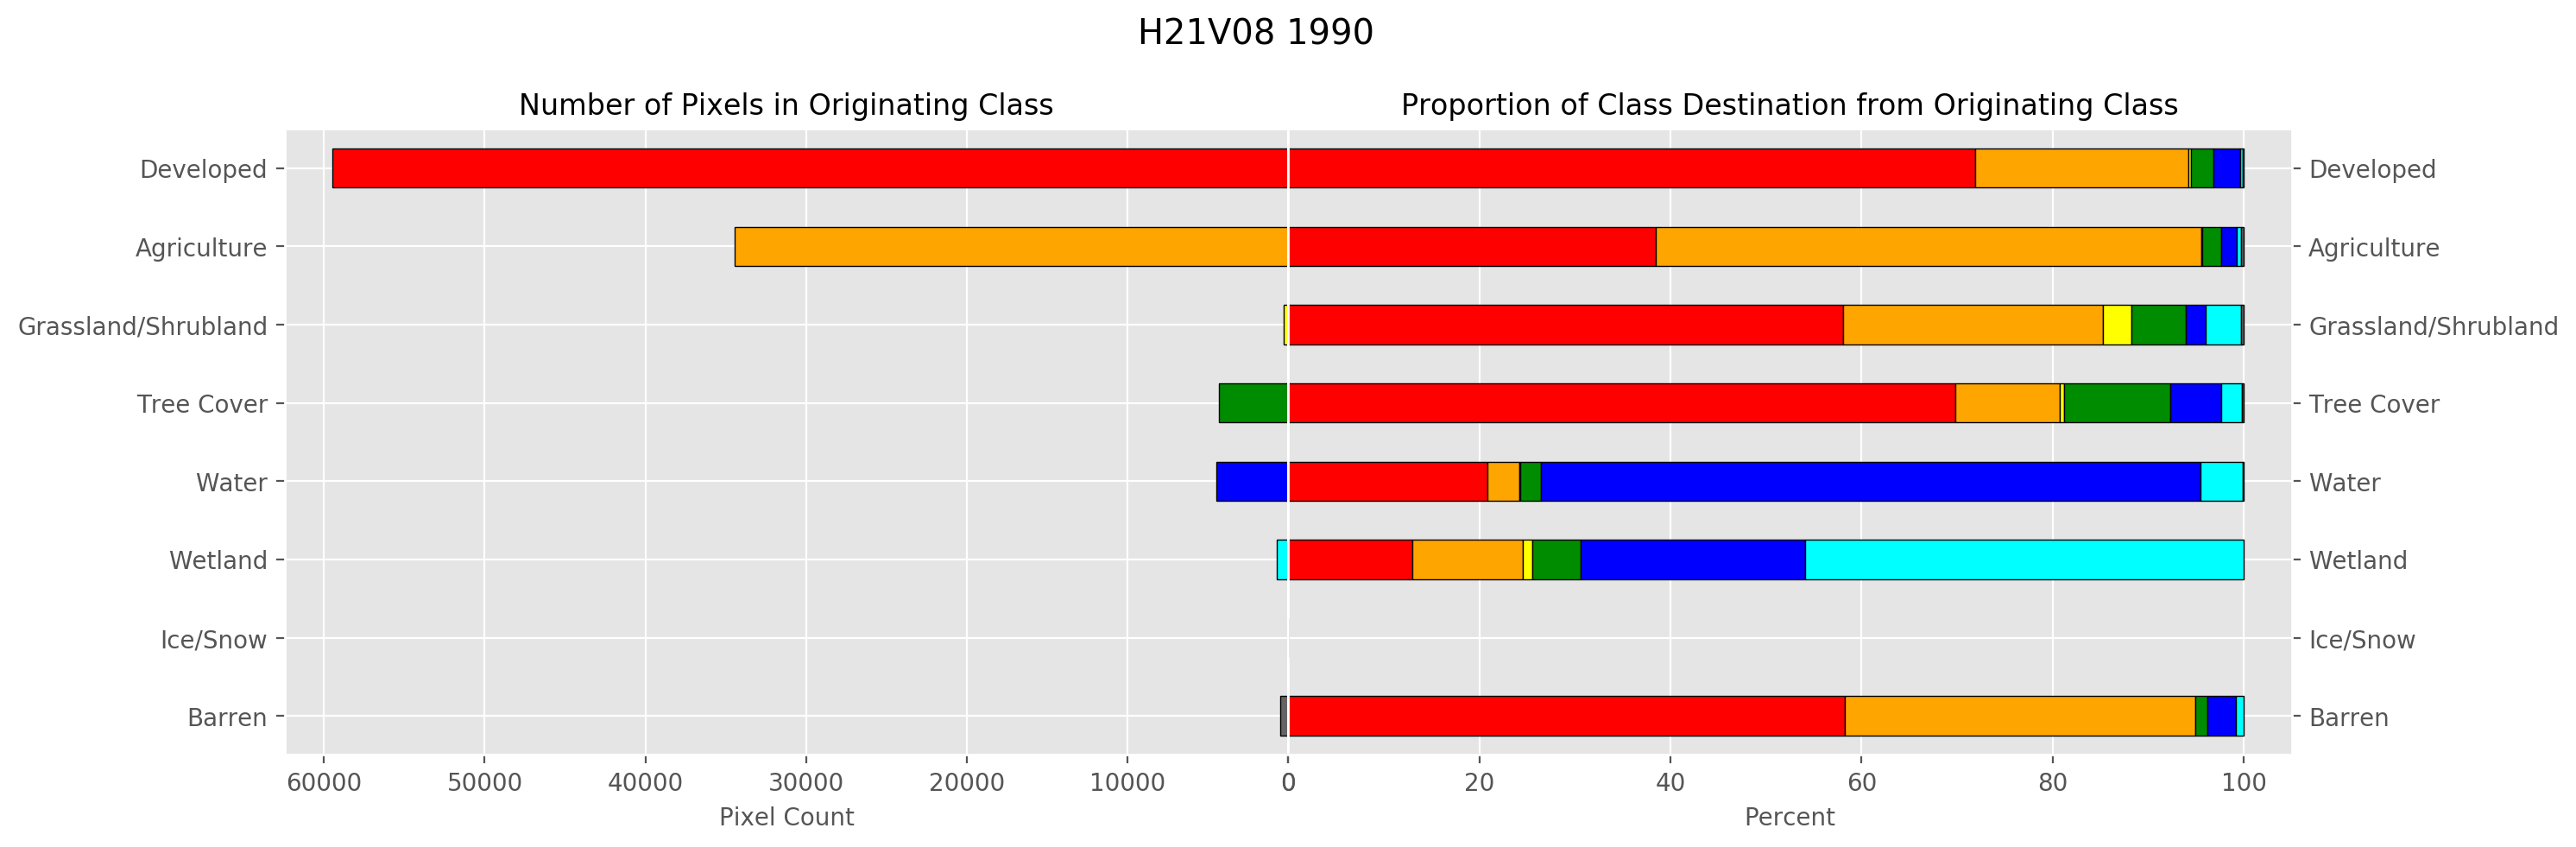

In [23]:
plt.close()

fig, (ax1, ax2) = plt.subplots(figsize=(15,5), dpi=200, nrows=1, ncols=2, sharex=False, sharey=True)

fig.subplots_adjust(wspace=0)

df_percents[:-1].plot.barh(stacked=True, color=colors_, ax=ax2, edgecolor='k', width=.5, legend=False)

for ind, total in enumerate(class_totals):
    ax1.barh(ind, total, color=colors_[ind], edgecolor='k', label=f"{ind+1} - {class_names[ind]}", height=0.5)
# ax1.barh(np.arange(0,8), class_totals, color=colors_, edgecolor='k', label="Class")

ax1.invert_yaxis()

ax1.invert_xaxis()


fig.suptitle(f"{tile} {year}", fontsize='x-large')
fig.subplots_adjust(top=0.85, )

ax1.set_title("Number of Pixels in Originating Class", fontsize='large')
ax2.set_title("Proportion of Class Destination from Originating Class", fontsize='large')

# ax1.set_ylabel("Originating Class", fontsize="medium")
ax1.set_xlabel("Pixel Count", fontsize="medium")

ax2.set_xlabel("Percent", fontsize="medium")
ax2.yaxis.tick_right()
# ax1.set_ylabel("Originating Class", fontsize="medium")
ax1.set_yticklabels(class_names)
plt.show()

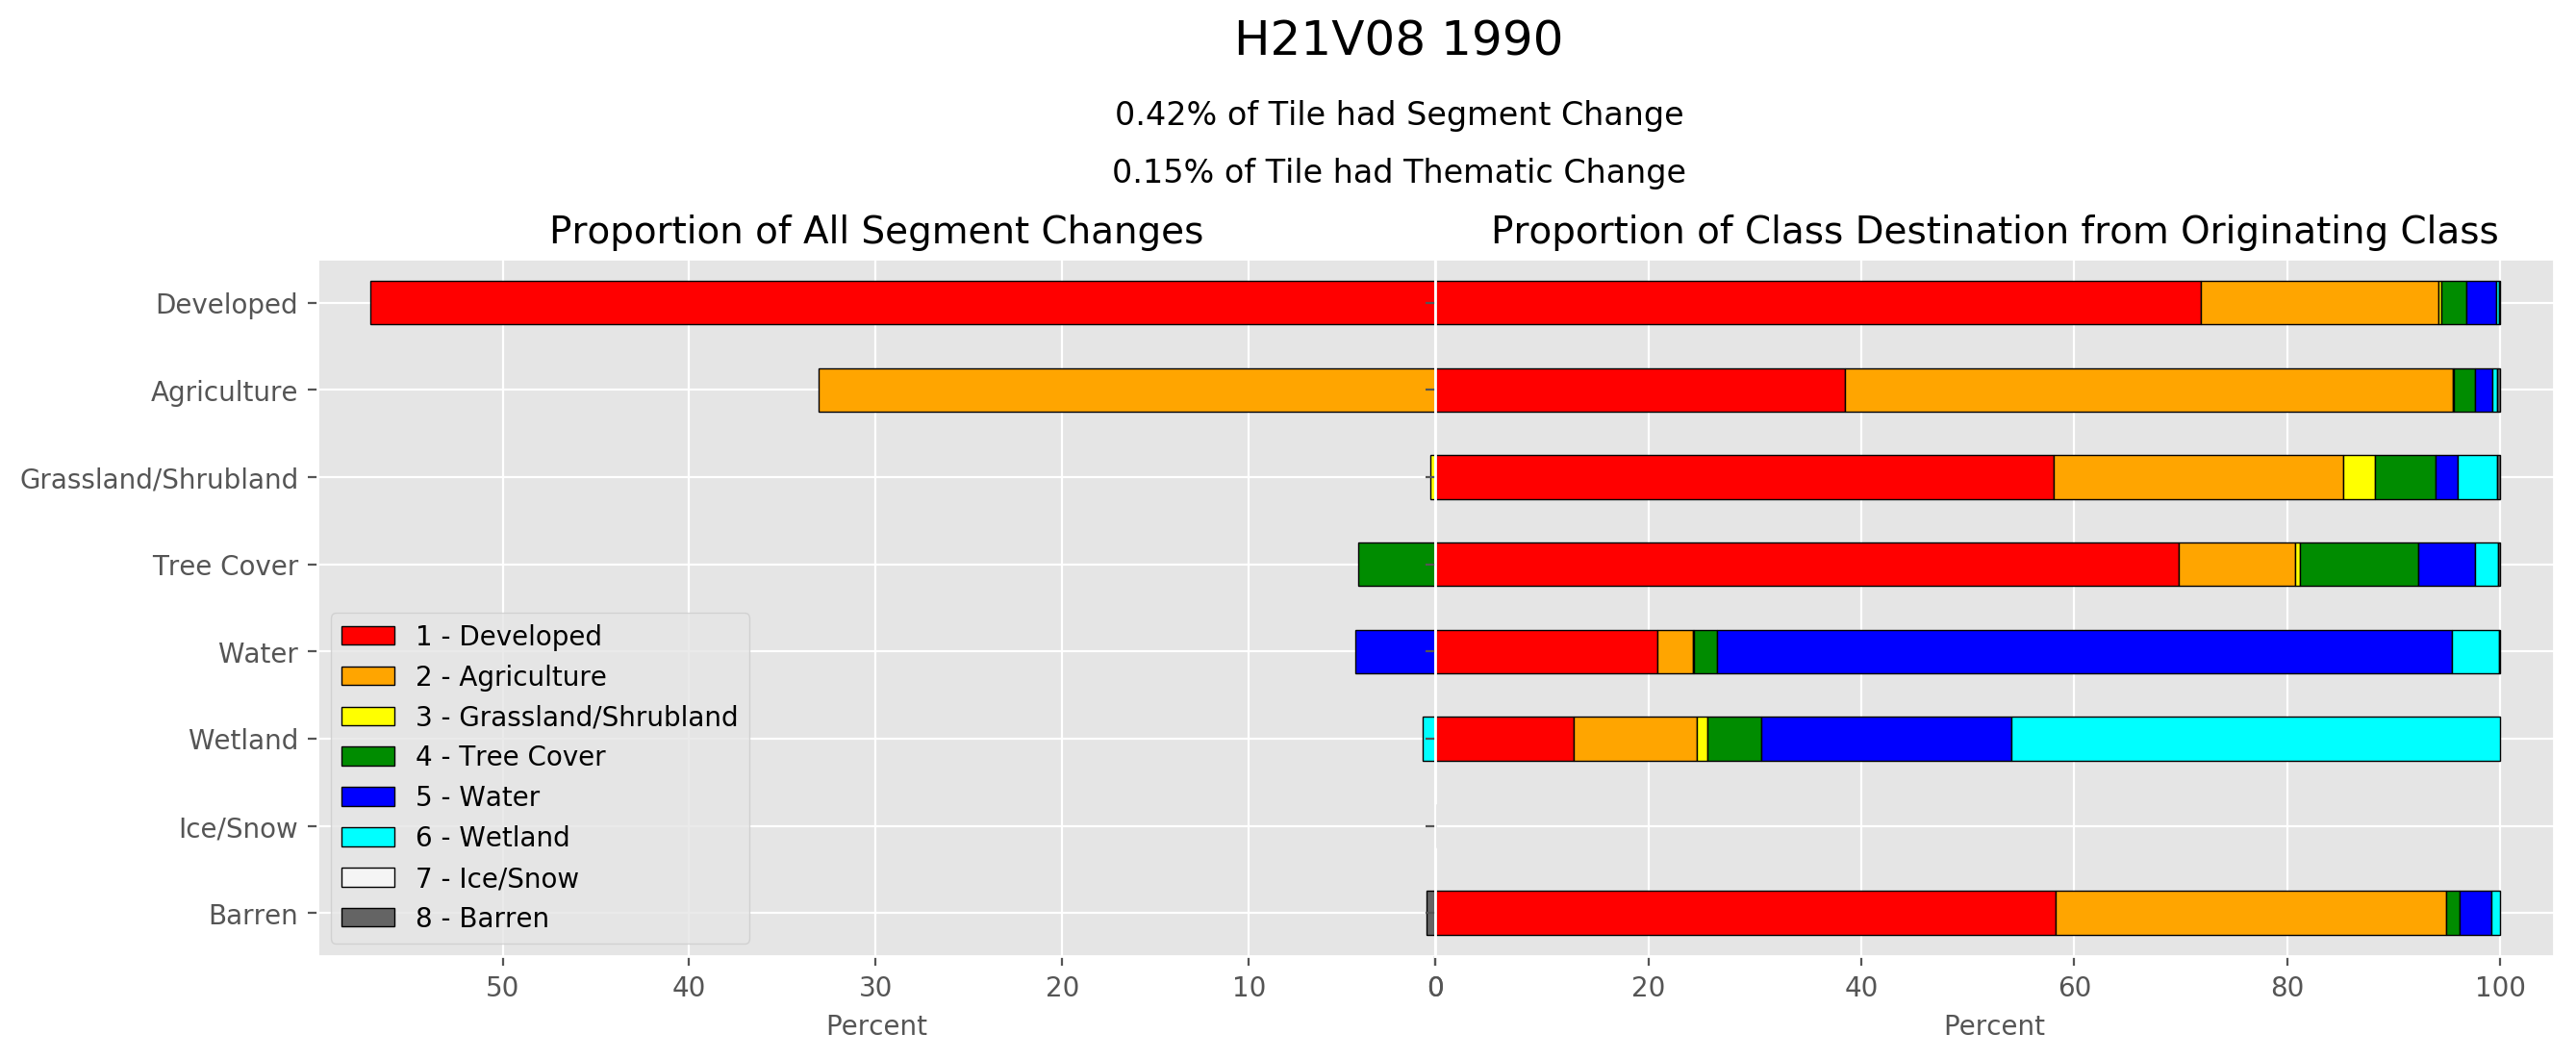

In [24]:
plt.close()

# Create figure with 2 subplots that share a y axis
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), dpi=200, nrows=1, ncols=2, sharex=False, sharey=True)

# Use the DataFrame df_percents to plot the proportion of change in each originating class on the right axis
df_percents[:-1].plot.barh(stacked=True, color=colors_, ax=ax2, edgecolor='k', width=.5, legend=False)

# Use array class_totals to plot the total/segment_total percentage on the left axis
for ind, total in enumerate(class_totals):
    # label isn't used, but necessary if a legend is desired on the figure
    ax1.barh(ind, total/segment_total * 100 , color=colors_[ind], edgecolor='k', 
             label=f"{ind+1} - {class_names[ind]}", height=0.5)
    
# Plot the first class at the top, this inverts the y-axis for both subplots because they share y
ax1.invert_yaxis()

# Invert the x axis on the left subplot so that it matches the origin of the right subplot
ax1.invert_xaxis()

# Show the y axis ticks on the right side of the right subplot
# ax2.yaxis.tick_right()

# Add figure title and subtitles
fig.suptitle(f"{tile} {year}",fontsize=18, y=1.10)
plt.figtext(.5, .99, f"{round(segment_percent, 2)}% of Tile had Segment Change", fontsize=12, ha='center')
plt.figtext(.5, .93, f"{round(final_percent, 2)}% of Tile had Thematic Change", fontsize=12, ha='center')

# Add subplot titles
ax1.set_title("Proportion of All Segment Changes", fontsize=14)
ax2.set_title("Proportion of Class Destination from Originating Class", fontsize=14)

# Add axes labels and titles
ax1.set_xlabel("Percent", fontsize="medium")
ax2.set_xlabel("Percent", fontsize="medium")
ax1.set_yticklabels(class_names)

# Adjust subplots to make figure less cluttered
fig.subplots_adjust(top=0.85, )
fig.subplots_adjust(wspace=0)

ax1.legend()

plt.show()

In [25]:
thematic_count = np.zeros(8, dtype=np.int)

In [26]:
thematic_count

array([0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
for ind, i in enumerate(counts):
    temp=np.copy(i)
    temp[ind]=0
    thematic_count[ind] = np.sum(temp)
thematic_total_count = np.sum(thematic_count)

In [28]:
thematic_total_count

37862

In [29]:
rects = None

In [30]:
figgg, axxx = plt.subplots()

In [31]:
rects = axxx.barh(np.arange(8), class_totals, color=colors_)

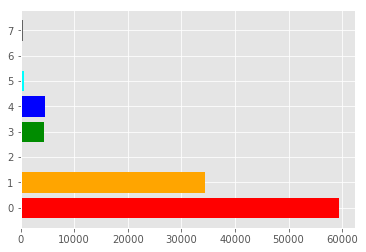

In [32]:
plt.show()

In [73]:
def autolabel(rects, ax, totals):
    """
    Generate labels for the horizontal bar plot.  Use the class totals as the label values
    :param rects:
    :param ax:
    :return:
    """

    for ind, rect in enumerate(rects):
        width = int(rect.get_width())

        if width < 10:
            xloc = width + 5
            clr="k"
            align = "right"
        else:
            xloc=0.98 * width
            clr="k"
            align="left"

        yloc = rect.get_y() + rect.get_height()/2.0

        label = ax.text(xloc, yloc, "{:02.2f} $km^2$".format(totals[ind]), ha=align, va="center",
                        color=clr, weight="bold", clip_on=True)

    return None

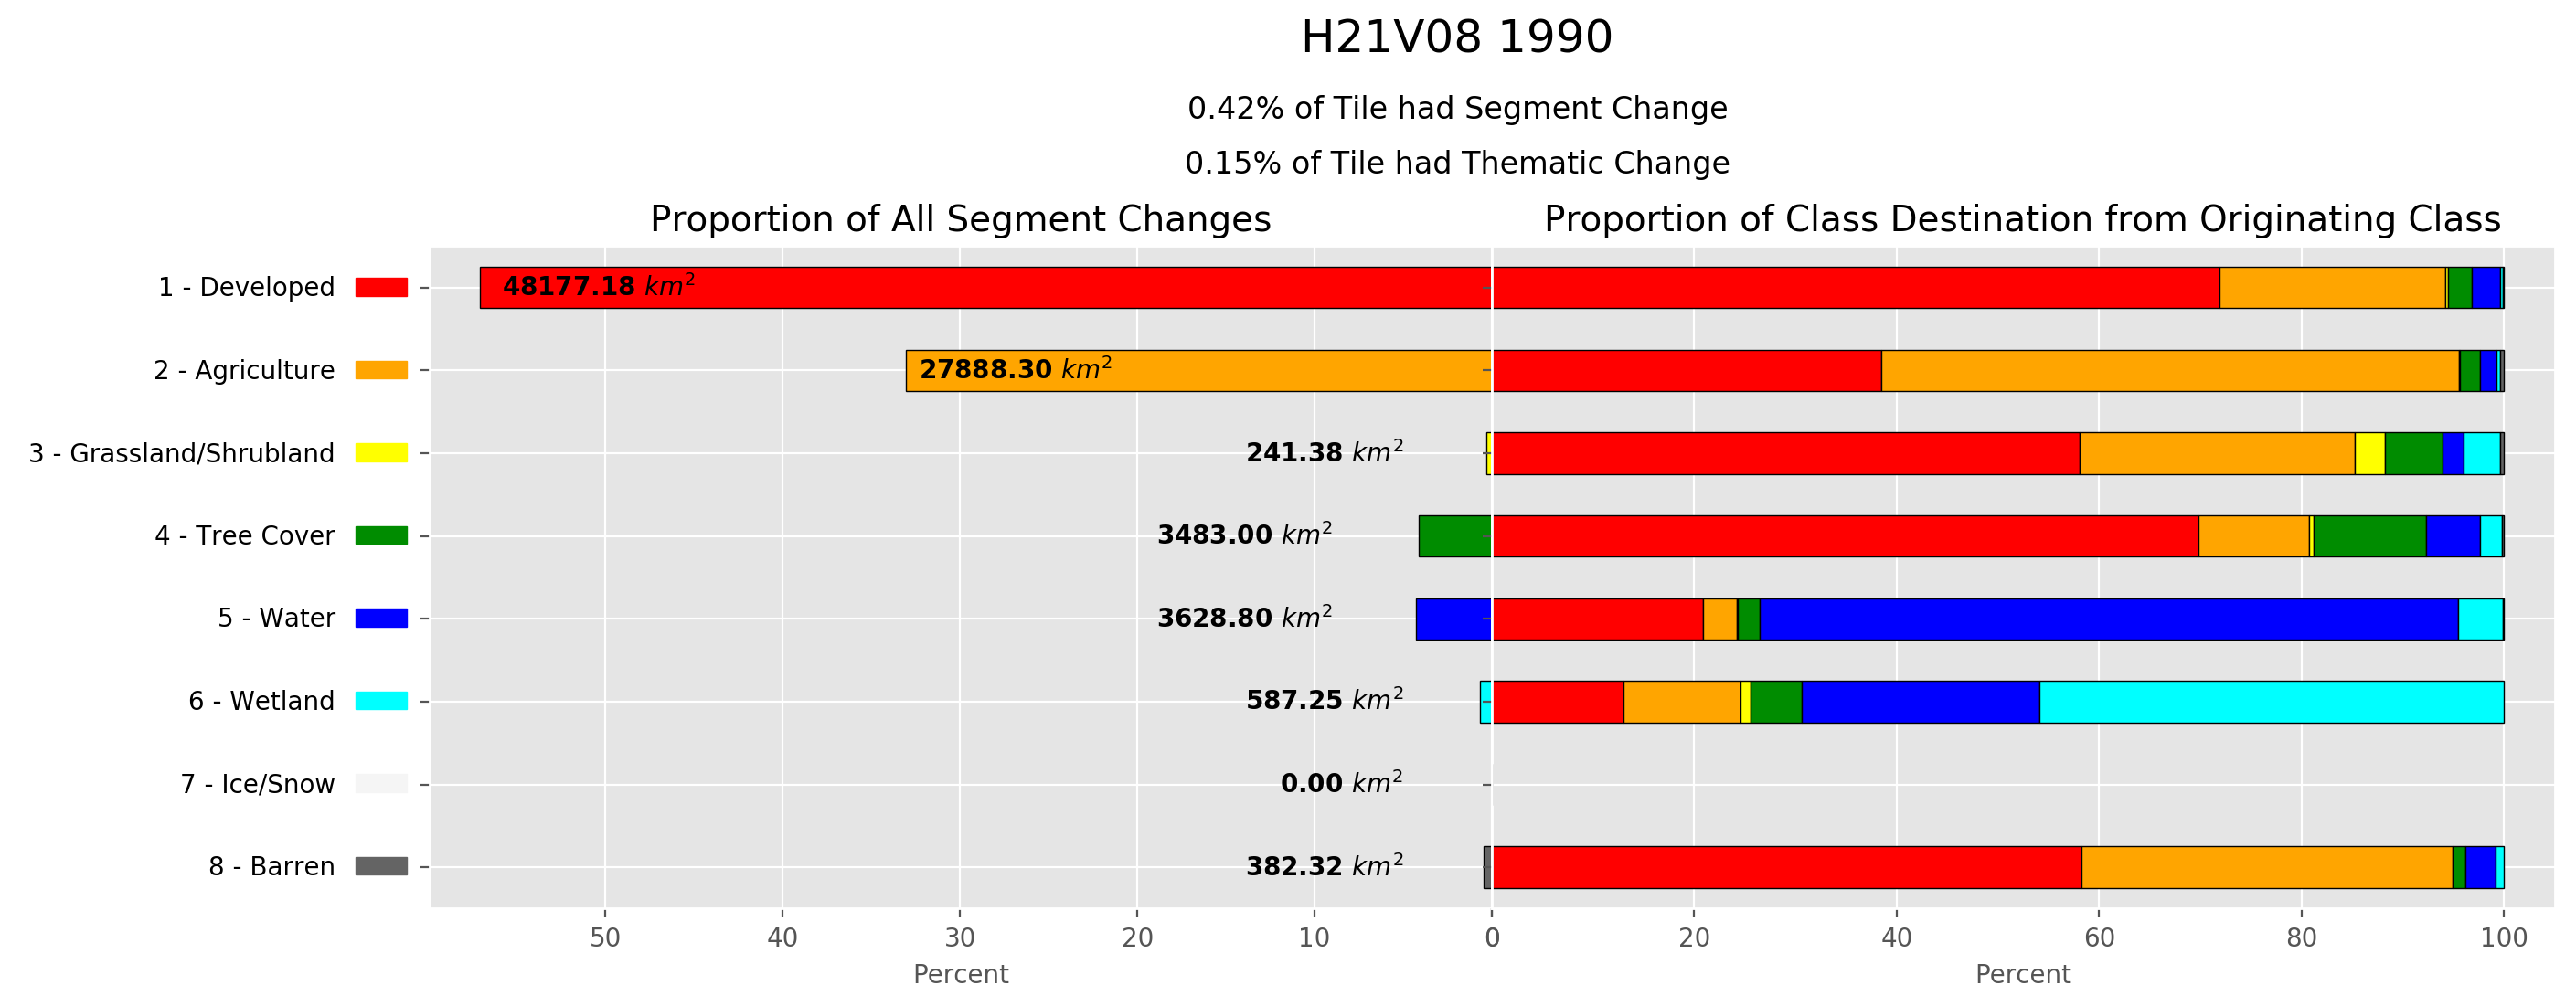

In [88]:
plt.close()



# Create figure with 2 subplots that share a y axis
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), dpi=200, nrows=1, ncols=2, sharex=False, sharey=True)

# Use the DataFrame df_percents to plot the proportion of change in each originating class on the right axis
df_percents[:-1].plot.barh(stacked=True, color=colors_, ax=ax2, edgecolor='k', width=.5, legend=False)

# Use array class_totals to plot the total/segment_total percentage on the left axis
# for ind, total in enumerate(class_totals):
    # label isn't used, but necessary if a legend is desired on the figure
#    ax1.barh(ind, total/segment_total * 100 , color=colors_[ind], edgecolor='k', 
#             label=f"{ind+1} - {class_names[ind]}", height=0.5)

# cmap = matplotlib.colors.ListedColormap(colors_)
# cb = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap, ticks = np.arange(8), orientation="vertical")

rects = ax1.barh(np.arange(8), class_segment_proportions, color=colors_, edgecolor="k", height=0.5)
# Plot the first class at the top, this inverts the y-axis for both subplots because they share y
ax1.invert_yaxis()

# Invert the x axis on the left subplot so that it matches the origin of the right subplot
ax1.invert_xaxis()

# Show the y axis ticks on the right side of the right subplot
# ax2.yaxis.tick_right()
# ax1.get_yaxis().set_visible(False)
ax1.set_yticklabels(['']*len(np.arange(8)))

autolabel(rects=rects, ax=ax1, totals=class_areas)

# Add figure title and subtitles
fig.suptitle(f"{tile} {year}",fontsize=18, y=1.10)
plt.figtext(.5, .99, f"{round(segment_percent, 2)}% of Tile had Segment Change", fontsize=12, ha='center')
plt.figtext(.5, .93, f"{round(final_percent, 2)}% of Tile had Thematic Change", fontsize=12, ha='center')

# Add subplot titles
ax1.set_title("Proportion of All Segment Changes", fontsize=14)
ax2.set_title("Proportion of Class Destination from Originating Class", fontsize=14)

# Add axes labels and titles
ax1.set_xlabel("Percent", fontsize="medium")
ax2.set_xlabel("Percent", fontsize="medium")


# Adjust subplots to make figure less cluttered
fig.subplots_adjust(top=0.85, )
fig.subplots_adjust(wspace=0)

dev_label = mpatches.Patch(color=colors_[0], label="1 - Developed")
ag_label = mpatches.Patch(color=colors_[1], label="2 - Agriculture")
grass_label = mpatches.Patch(color=colors_[2], label="3 - Grassland/Shrubland")
tree_label = mpatches.Patch(color=colors_[3], label="4 - Tree Cover")
water_label = mpatches.Patch(color=colors_[4], label="5 - Water")
wet_label = mpatches.Patch(color=colors_[5], label="6 - Wetland")
ice_label = mpatches.Patch(color=colors_[6], label="7 - Ice/Snow")
bar_label = mpatches.Patch(color=colors_[7], label="8 - Barren")
handles=[dev_label, ag_label, grass_label, tree_label, water_label, wet_label, ice_label, bar_label]
#ax = fig.add_subplot()

ax1.legend(handles=handles, loc="upper right", bbox_to_anchor=(0, 0.99), ncol=1, labelspacing=2.25, markerfirst=False, facecolor="w", frameon=False )

plt.show()